# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
#import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
X_train = np.load('data/x_train.npy')
y_train = np.load('data/y_train.npy')

X_test = np.load('data/x_test.npy')
y_test = np.load('data/y_test.npy')

X_val = np.load('data/x_val.npy')
y_val = np.load('data/y_val.npy')

# DT Feature Selection

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
import time

In [5]:
start_time = time.time()

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

print(f"Seconds: {time.time() - start_time}")

Seconds: 19.842571258544922


In [6]:
feature_importances = clf.feature_importances_
feature_importances = np.array(feature_importances)

feature_importances

array([4.25649439e-04, 2.27843747e-01, 5.67413500e-02, 6.01118228e-03,
       4.83521855e-03, 1.84897351e-02, 0.00000000e+00, 1.62580684e-02,
       1.94414533e-03, 1.00301575e-02, 1.15674132e-01, 1.05869682e-02,
       0.00000000e+00, 0.00000000e+00, 1.37696206e-02, 1.90166277e-02,
       3.01795020e-05, 5.64468352e-03, 3.68200803e-02, 1.22150200e-02,
       1.14292778e-03, 5.27178771e-03, 4.29308892e-03, 4.25429407e-04,
       2.16374501e-02, 3.65831527e-04, 1.16651471e-02, 1.73052354e-03,
       2.06840978e-02, 1.08066153e-03, 4.66241520e-03, 1.15952394e-03,
       3.86447118e-04, 5.47284838e-04, 1.09945242e-03, 5.23449920e-04,
       5.66000588e-04, 1.74863835e-03, 5.48326183e-04, 3.05622869e-04,
       3.60064823e-03, 5.41276029e-03, 1.20572715e-03, 6.35955422e-04,
       9.79870090e-03, 6.59661812e-04, 9.39793782e-03, 8.33772252e-03,
       2.19886657e-01, 7.66271495e-04, 1.39418605e-05, 9.75958288e-03,
       4.35042735e-02, 1.00931593e-04, 3.21843840e-04, 1.71627707e-04,
      

In [7]:
threshold = 0.001
selected_indices = np.where(feature_importances > threshold)[0]
print(f"Number of features selected: {len(selected_indices)}")

Number of features selected: 37


In [8]:
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]
X_val_selected = X_val[:, selected_indices]

In [9]:
y_train = np.where(y_train == 11, 0, 1)
y_test = np.where(y_test == 11, 0, 1)
y_val = np.where(y_val == 11, 0, 1)

## Short Test

In [10]:
clf_selected = DecisionTreeClassifier(random_state=42)
clf_selected.fit(X_train_selected, y_train)

y_pred = clf_selected.predict(X_test_selected)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 Score with selected features: {f1_macro}")

Macro F1 Score with selected features: 0.994433347474842


# PyDeepInsight

In [12]:
from pyDeepInsight import ImageTransformer

In [13]:
it = ImageTransformer(
    pixels=8,
    feature_extractor='tsne',
    discretization='lsa'
)

In [14]:
it.fit(X_train_selected)
X_train_images = it.transform(X_train_selected, 'pytorch')

X_test_images = it.transform(X_test_selected, 'pytorch')

X_val_images = it.transform(X_val_selected, 'pytorch')

In [15]:
def view_pytorch_images_grid(images, indices=None, rows=1, cols=5):

    if indices is None:
        num_images = min(rows * cols, len(images))
        indices = range(num_images)
    else:
        num_images = len(indices)
        rows = (num_images + cols - 1) // cols 

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        image = images[idx]
        channels = image.shape[0]

        if channels == 1:
            image_to_show = image[0]
            ax.imshow(image_to_show, cmap='gray')
        else:
            image_to_show = np.transpose(image, (1, 2, 0))
            ax.imshow(image_to_show)

        ax.set_title(f'Index {idx}')
        ax.axis('off')

    for ax in axes[len(indices):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


## Visuals

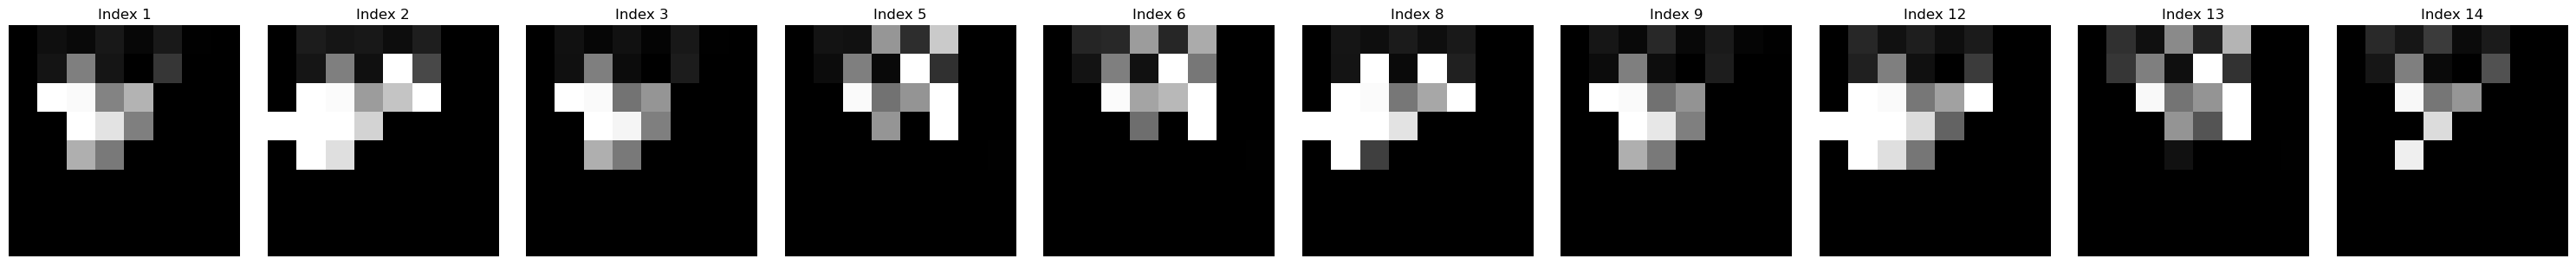

In [16]:
view_pytorch_images_grid(X_train_images, indices=np.where(y_train == 1)[0][:10], rows=1, cols=10)
# Anomaly

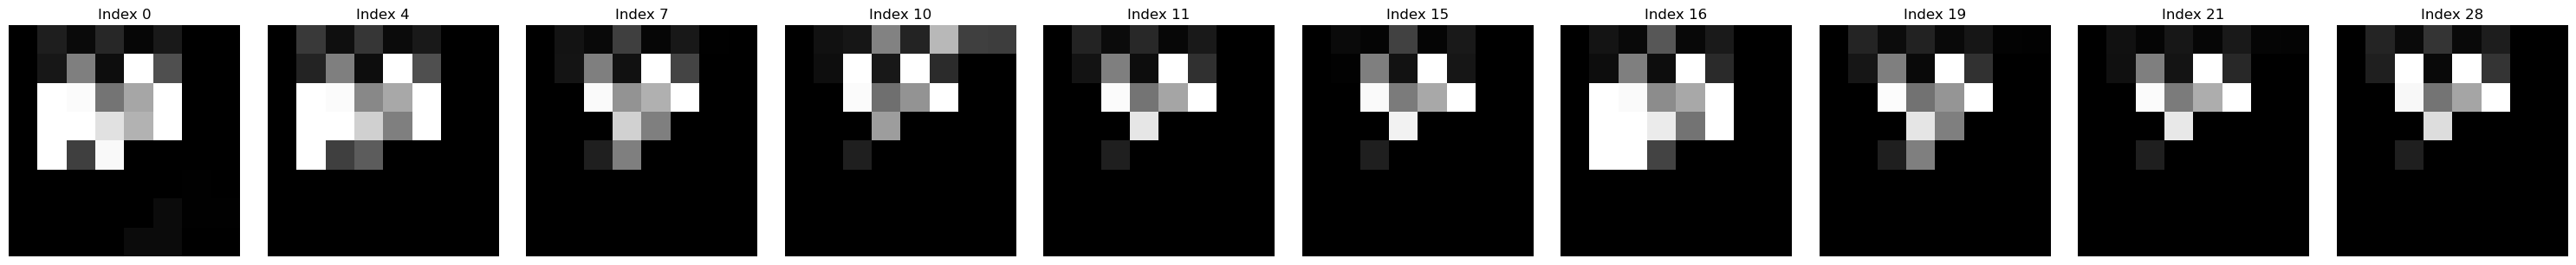

In [17]:
view_pytorch_images_grid(X_train_images, indices=np.where(y_train == 0)[0][:10], rows=1, cols=10)
# Normal

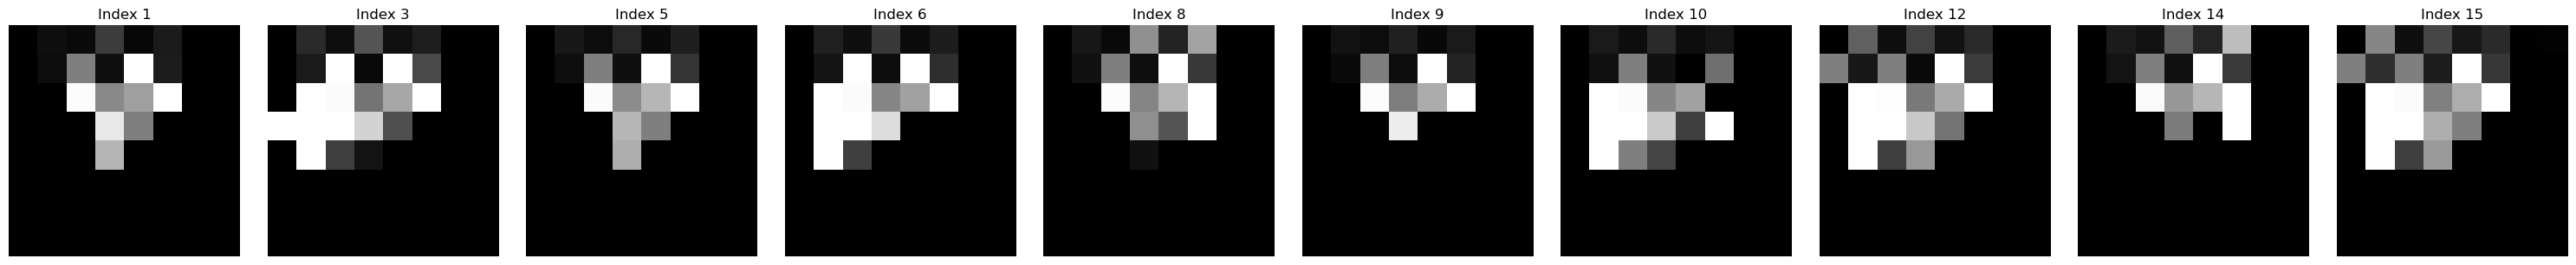

In [18]:
view_pytorch_images_grid(X_test_images, indices=np.where(y_test == 1)[0][:10], rows=1, cols=10)
# Anomaly

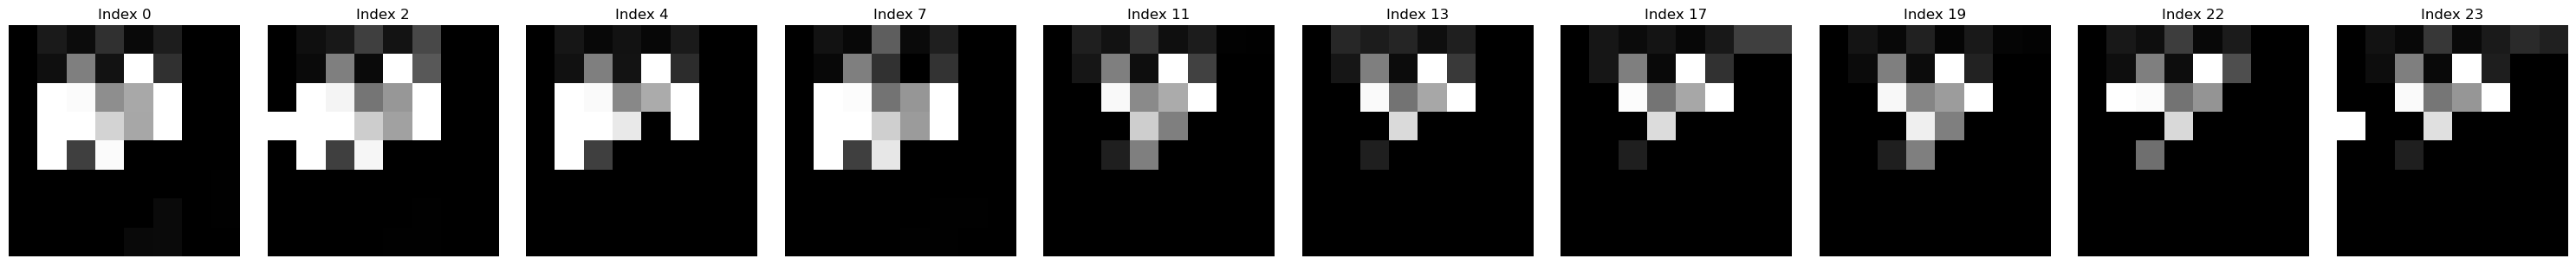

In [19]:
view_pytorch_images_grid(X_test_images, indices=np.where(y_test == 0)[0][:10], rows=1, cols=10)
# Normal

In [20]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([259964, 188771]))

# MAE Model

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [30]:
num_samples, channels, img_height, img_width = X_train_images.shape
latent_dim = 16

In [21]:
class Encoder(nn.Module):
    def __init__(self, img_channels=1, feature_dim=32, latent_dim=2):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32 * 2 * 2, feature_dim)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Output: (batch_size, 16, 8, 8)
        x = self.pool(x)              # Output: (batch_size, 16, 4, 4)
        x = self.relu(self.conv2(x))  # Output: (batch_size, 32, 4, 4)
        x = self.pool(x)              # Output: (batch_size, 32, 2, 2)
        x = x.view(x.size(0), -1)     # Flatten to (batch_size, 128)
        x = self.fc1(x)               # Output: (batch_size, feature_dim)
        return x

In [22]:
class Decoder(nn.Module):
    def __init__(self, img_channels=1, feature_dim=32):
        super(Decoder, self).__init__()
        self.fc2 = nn.Linear(feature_dim, 32 * 2 * 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        self.deconv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose2d(16, img_channels, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, z):
        x = self.relu(self.fc2(z))           # Output: (batch_size, 128)
        x = x.view(x.size(0), 32, 2, 2)      # Reshape to (batch_size, 32, 2, 2)
        x = self.upsample(x)                 # Upsample to (batch_size, 32, 4, 4)
        x = self.relu(self.deconv1(x))       # Output: (batch_size, 16, 4, 4)
        x = self.upsample(x)                 # Upsample to (batch_size, 16, 8, 8)
        x = self.sigmoid(self.deconv2(x))    # Output: (batch_size, img_channels, 8, 8)
        return x

In [34]:
class MAE(nn.Module):
    def __init__(self, img_channels=1, feature_dim=32, latent_dim=2):
        super(MAE, self).__init__()
        self.encoder = Encoder(img_channels, feature_dim, latent_dim)
        self.decoder = Decoder(img_channels, feature_dim)

    def mask_input(self, x, mask_ratio=0.25):
        # Generate a mask with 0s and 1s, keeping only (1-mask_ratio) of the original input
        mask = torch.rand(x.shape, device=x.device) > mask_ratio
        x_masked = x * mask
        return x_masked, mask

    def forward(self, x, mask_ratio=0.25):
        x_masked, mask = self.mask_input(x, mask_ratio)  # Apply masking to input
        z = self.encoder(x_masked)
        reconstructed = self.decoder(z)
        return reconstructed, mask


In [24]:
def mae_loss_function(reconstructed, original, mask):
    # Only calculate reconstruction loss on the masked parts
    masked_original = original * mask
    reconstruction_loss = F.mse_loss(reconstructed, masked_original, reduction='sum')
    return reconstruction_loss

# MAE Training

In [25]:
normal_indices = np.where(y_train == 0)[0]
X_train_normal = X_train_images[normal_indices]
y_train_normal = y_train[normal_indices]

In [26]:
X_train_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_images, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_images, dtype=torch.float32)

/tmp/ipykernel_177/2228886096.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
/tmp/ipykernel_177/2228886096.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test_images, dtype=torch.float32)
/tmp/ipykernel_177/2228886096.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val_images, dtype=torch.float32)


In [27]:
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor, torch.tensor(y_test, dtype=torch.long))
val_dataset = TensorDataset(X_val_tensor, torch.tensor(y_val, dtype=torch.long))

batch_size = 32 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [28]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

8124
4383
3506


In [38]:
model = MAE(img_channels=channels, feature_dim=32, latent_dim=latent_dim).to(device)
img_channels = X_train_tensor.shape[1]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

mask_ratio = 0.75

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss = 0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch}/{num_epochs}', leave=True)

    for batch_idx, (data,) in progress_bar:
        data = data.to(device)

        optimizer.zero_grad()

        reconstructed, mask = model(data, mask_ratio=mask_ratio)

        loss = mae_loss_function(reconstructed, data, mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Average Training Loss: {avg_loss:.4f}')

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)

            reconstructed, mask = model(data, mask_ratio=mask_ratio)
            loss = mae_loss_function(reconstructed, data, mask)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f'Epoch {epoch}, Average Validation Loss: {avg_val_loss:.4f}')

Epoch 1/20: 100%|██████████| 8124/8124 [00:26<00:00, 312.00it/s]


Epoch 1, Average Training Loss: 3.0860
Epoch 1, Average Validation Loss: 1.4242


Epoch 2/20: 100%|██████████| 8124/8124 [00:24<00:00, 332.67it/s]


Epoch 2, Average Training Loss: 0.8988
Epoch 2, Average Validation Loss: 0.8096


Epoch 3/20: 100%|██████████| 8124/8124 [00:27<00:00, 299.21it/s]


Epoch 3, Average Training Loss: 0.5868
Epoch 3, Average Validation Loss: 0.6540


Epoch 4/20: 100%|██████████| 8124/8124 [00:24<00:00, 326.47it/s]


Epoch 4, Average Training Loss: 0.4793
Epoch 4, Average Validation Loss: 0.5872


Epoch 5/20: 100%|██████████| 8124/8124 [00:24<00:00, 333.36it/s]


Epoch 5, Average Training Loss: 0.4128
Epoch 5, Average Validation Loss: 0.5151


Epoch 6/20: 100%|██████████| 8124/8124 [00:24<00:00, 336.41it/s]


Epoch 6, Average Training Loss: 0.3651
Epoch 6, Average Validation Loss: 0.4660


Epoch 7/20: 100%|██████████| 8124/8124 [00:24<00:00, 334.65it/s]


Epoch 7, Average Training Loss: 0.3377
Epoch 7, Average Validation Loss: 0.4366


Epoch 8/20: 100%|██████████| 8124/8124 [00:25<00:00, 317.81it/s]


Epoch 8, Average Training Loss: 0.3199
Epoch 8, Average Validation Loss: 0.4265


Epoch 9/20: 100%|██████████| 8124/8124 [00:25<00:00, 322.15it/s]


Epoch 9, Average Training Loss: 0.3072
Epoch 9, Average Validation Loss: 0.4178


Epoch 10/20: 100%|██████████| 8124/8124 [00:23<00:00, 341.29it/s]


Epoch 10, Average Training Loss: 0.2986
Epoch 10, Average Validation Loss: 0.4165


Epoch 11/20: 100%|██████████| 8124/8124 [00:24<00:00, 330.46it/s]


Epoch 11, Average Training Loss: 0.2907
Epoch 11, Average Validation Loss: 0.4072


Epoch 12/20: 100%|██████████| 8124/8124 [00:24<00:00, 335.13it/s]


Epoch 12, Average Training Loss: 0.2845
Epoch 12, Average Validation Loss: 0.4067


Epoch 13/20: 100%|██████████| 8124/8124 [00:25<00:00, 319.21it/s]


Epoch 13, Average Training Loss: 0.2780
Epoch 13, Average Validation Loss: 0.3927


Epoch 14/20: 100%|██████████| 8124/8124 [00:26<00:00, 302.35it/s]


Epoch 14, Average Training Loss: 0.2744
Epoch 14, Average Validation Loss: 0.3907


Epoch 15/20: 100%|██████████| 8124/8124 [00:24<00:00, 326.34it/s]


Epoch 15, Average Training Loss: 0.2651
Epoch 15, Average Validation Loss: 0.3829


Epoch 16/20: 100%|██████████| 8124/8124 [00:26<00:00, 302.49it/s]


Epoch 16, Average Training Loss: 0.2571
Epoch 16, Average Validation Loss: 0.3788


Epoch 17/20: 100%|██████████| 8124/8124 [00:24<00:00, 326.62it/s]


Epoch 17, Average Training Loss: 0.2520
Epoch 17, Average Validation Loss: 0.3597


Epoch 18/20: 100%|██████████| 8124/8124 [00:23<00:00, 340.15it/s]


Epoch 18, Average Training Loss: 0.2456
Epoch 18, Average Validation Loss: 0.3496


Epoch 19/20: 100%|██████████| 8124/8124 [00:24<00:00, 335.70it/s]


Epoch 19, Average Training Loss: 0.2377
Epoch 19, Average Validation Loss: 0.3579


Epoch 20/20: 100%|██████████| 8124/8124 [00:24<00:00, 337.11it/s]


Epoch 20, Average Training Loss: 0.2311
Epoch 20, Average Validation Loss: 0.3473


In [39]:
torch.save(model.state_dict(), "deepinsight_mae_normal.pth")

# Reconstruction Classification

In [46]:
model = MAE(img_channels=3, feature_dim=32, latent_dim=16).to(device)
model.load_state_dict(torch.load("deepinsight_mae_normal.pth"))

<All keys matched successfully>

In [47]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve
)

In [110]:
def compute_reconstruction_errors(model, data_loader, mask_ratio=0.75):
    model.eval()
    reconstruction_errors = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='evaluating'):
            if len(batch) == 1:
                data = batch[0]
            elif len(batch) == 2:
                data, label = batch
                labels.extend(label.cpu().numpy())
            else:
                raise ValueError("Unexpected batch size. Expected 1 or 2 elements in batch.")

            data = data.to(device)
            
            reconstructed, mask = model(data, mask_ratio=mask_ratio)
            loss = F.mse_loss(reconstructed, data, reduction='sum')

            mask = mask.float()
            mask = mask.expand_as(data)

            loss = loss * (1 - mask)

            loss = loss.view(loss.size(0), -1).mean(dim=1) 
            reconstruction_errors.extend(loss.cpu().numpy())

    return np.array(reconstruction_errors)#, np.array(labels)

In [111]:
reconstruction_errors_train = compute_reconstruction_errors(model, train_loader)
reconstruction_errors_val = compute_reconstruction_errors(model, val_loader)
reconstruction_errors_test = compute_reconstruction_errors(model, test_loader)

evaluating: 100%|██████████| 4383/4383 [00:05<00:00, 875.66it/s]


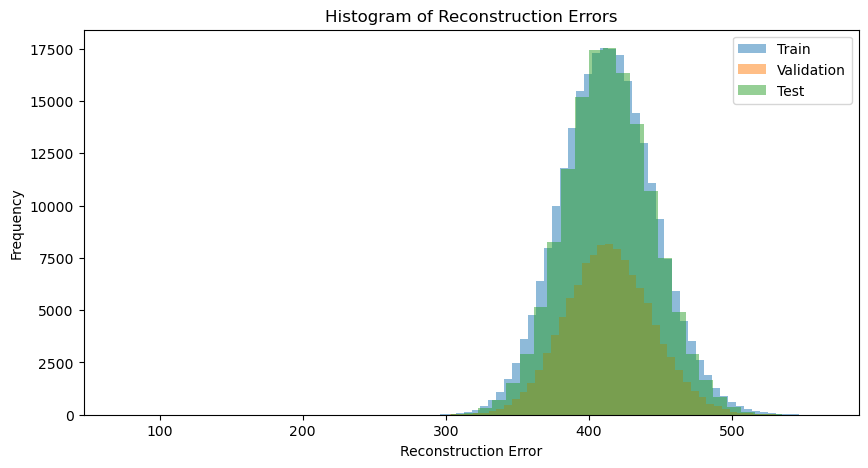

In [112]:
# Plot histograms of reconstruction errors
plt.figure(figsize=(10, 5))
plt.hist(reconstruction_errors_train, bins=50, alpha=0.5, label='Train')
plt.hist(reconstruction_errors_val, bins=50, alpha=0.5, label='Validation')
plt.hist(reconstruction_errors_test, bins=50, alpha=0.5, label='Test')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Reconstruction Errors')
plt.show()

In [115]:
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors_test)
roc_auc = auc(fpr, tpr)

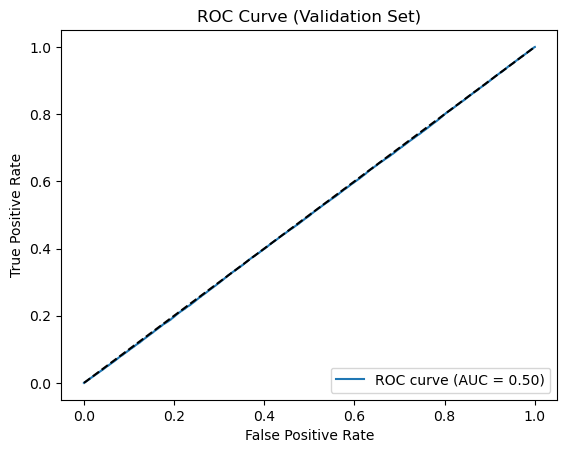

In [116]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Set)')
plt.legend(loc='lower right')
plt.show()

In [41]:
fpr, tpr, thresholds = roc_curve(y_test, reconstruction_errors_test)
roc_auc = auc(fpr, tpr)

f1_scores = []
for threshold in tqdm(thresholds, desc="evaluating thresholds"):
    y_pred = (reconstruction_errors_test >= threshold).astype(int)  # Convert to binary prediction
    f1 = f1_score(y_test, y_pred, average='binary')
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold for F1 score: {optimal_threshold}')

evaluating thresholds: 100%|██████████| 27603/27603 [08:37<00:00, 53.33it/s]

Optimal Threshold for F1 score: 0.0164073146879673


In [43]:
y_pred = (reconstruction_errors_test > optimal_threshold).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision (binary): {precision_macro:.4f}')
print(f'Recall (binary): {recall_macro:.4f}')
print(f'F1 Score (binary): {f1_macro:.4f}')

Accuracy: 0.8803
Precision (binary): 0.8801
Recall (binary): 0.8803
F1 Score (binary): 0.8801
